<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 8 : Recommandation de films par filtrage collaboratif

## Résumé

Le but de ce laboratoire est d'entraîner et de tester plusieurs méthodes de recommandation par filtrage collaboratif :
* plusieurs *baselines* (notes moyennes par utilisateur ou par film)
* deux approches *memory-based* (modèle utilisateur-utilisateur ou film-film)
* une approche *model-based* (réduction de dimensionnalité)

Un jeu de données d'entraînement est fourni, ainsi qu'un jeu de validation, sur lequel vous pourrez tester vos méthodes et choisir les paramètres donnant les meilleurs résultats.

**Pour rendre ce travail,** veuillez répondre aux questions en écrivant le code demandé, résumer les tests effectués, et comparer entre eux les scores obtenus.  Veuillez ensuite rendre le notebook sur Cyberlearn.

**Pour participer à la compétition**, veuillez rendre séparément sur Cyberlearn un notebook qui permet d'exécuter seulement votre meilleure méthode sur les données de validation (nous les remplacerons par celles de test) ; veuillez rendre également le modèle qui est utilisé par votre notebook.

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm # permet d'afficher la progression de l'exécution

## 1. Analyse exploratoire des données

Le groupe de recherche GroupLens met à disposition le [jeu de données MovieLens](http://files.grouplens.org/datasets/movielens/) contenant 20 millions de *ratings*, c'est-à-dire des notes données à des films par des utilisateurs.  Pour simplifier, deux extraits des données sont fournis dans les fichiers `ratings_train.csv` et `ratings_valid.csv` sur Cyberlearn.  

Ces fichiers contiennent les index originaux des utilisateurs et des films, ainsi que des index nouveaux (*new*) qui vont de 1 à `n_users` et de 1 à `n_movies` sans discontinuer. 

Note : GroupLens fournit aussi d'autres informations, notamment une correspondance entre les index originaux des films et leurs titres.  En revanche, les utilisateurs sont toujours anonymisés et sont désignés par leurs index.

**1a.** Veuillez charger les deux extraits de données dans deux *dataframes* appelées `train_df` et `valid_df`.
* Veuillez afficher les 3 premières lignes de chacune.
* Combien de *ratings* contient chacune des *dataframes* ?
* Quels sont les valeurs minimale, maximale, et moyenne des *ratings* dans chaque *dataframe* ?

In [108]:
train_df = pd.read_csv('data/ratings_train.csv')
valid_df = pd.read_csv('data/ratings_valid.csv')

In [109]:
train_df.head(3)

,userId,movieId,rating,newMovieId,newUserId
0,112988,44191,8,797,831
1,10012,3052,8,707,74
2,97826,3948,8,562,714


In [110]:
valid_df.head(3)

,userId,movieId,rating,newMovieId,newUserId
0,99342,10,6,7,725
1,107579,1729,6,679,795
2,134156,2881,5,475,971


In [111]:
print("train_df contient {} ratings".format(train_df.shape[0]))
print("valid_df contient {} ratings".format(valid_df.shape[0]))

train_df contient 598095 ratings
valid_df contient 33227 ratings


In [112]:
train_df['rating'].describe()

count    598095.000000
mean          6.848430
std           2.018841
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          10.000000
Name: rating, dtype: float64

In [113]:
valid_df['rating'].describe()

count    33227.000000
mean         6.871430
std          2.022735
min          1.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         10.000000
Name: rating, dtype: float64

**1b. Vérifications.** Quelles sont les plus petites et les plus grandes valeurs des *nouveaux* index des utilisateurs et des films, dans chacune des deux dataframes ?  Combien de valeurs différentes y a-t-il ? Est-ce qu'il y a des index manquants ?

In [114]:
print("train_df newMovieId   min : ",train_df['newMovieId'].min(), ", max : ", train_df['newMovieId'].max(), ", unique : ", train_df['newMovieId'].nunique(), ", missing" , train_df['newMovieId'].isnull().sum())
print("train_df newUserId    min : ",train_df['newUserId'].min(), ", max : ", train_df['newUserId'].max(), ", unique : ", train_df['newUserId'].nunique(), ", missing" , train_df['newUserId'].isnull().sum())
print()
print("valid_df newMovieId   min : ",valid_df['newMovieId'].min(), ", max : ", valid_df['newMovieId'].max(), ", unique : ", valid_df['newMovieId'].nunique(), ", missing" , valid_df['newMovieId'].isnull().sum())
print("valid_df newUserId    min : ",valid_df['newUserId'].min(), ", max : ", valid_df['newUserId'].max(), ", unique : ", valid_df['newUserId'].nunique(), ", missing" , valid_df['newUserId'].isnull().sum())

print("\nComparaison avec les ids originaux")
print("traind_df user_id min : ", train_df['userId'].min(), ", max : ", train_df['userId'].max(), ", unique : ", train_df['userId'].nunique(), ", missing" , train_df['userId'].isnull().sum())

train_df newMovieId   min :  1 , max :  1000 , unique :  1000 , missing 0
train_df newUserId    min :  1 , max :  1000 , unique :  1000 , missing 0

valid_df newMovieId   min :  1 , max :  1000 , unique :  1000 , missing 0
valid_df newUserId    min :  1 , max :  1000 , unique :  1000 , missing 0

Comparaison avec les ids originaux
traind_df user_id min :  156 , max :  138208 , unique :  1000 , missing 0


**1c.** Veuillez d'abord définir les variables `n_users` et `n_movies` qui stockent le nombre d'utilisateurs et de films différents.  Quel est le nombre moyen de *ratings* par utilisateur ?  Et par film ?

Dans `train_df`, combien de *ratings* possède le film le plus souvent évalué ?  (Autrement dit, quel est le nombre maximal de *ratings* d'un film ?)  Combien de *ratings* possède le film le moins souvent évalué ?  

Indication : pour calculer le nombre de ratings par film, appliquer `groupby()` puis `count()` sur la *dataframe*. 

Dans `train_df`, combien de *ratings* a formulé l'utilisateur qui s'est le plus souvent exprimé ?  (Autrement dit, quel est le nombre maximal de *ratings* donnés par un utilisateur ?)  Combien de *ratings* a formulé l'utilisateur qui s'est le moins souvent exprimé ?

In [115]:
N_USERS = train_df['newUserId'].nunique()
N_MOVIES = train_df['newMovieId'].nunique()

print("n_users = ", N_USERS, ", n_movies = ", N_MOVIES)

#Nombre moyen de ratings par utilisateur/par film
print("Nombre moyen de ratings par utilisateur : ", train_df.groupby('newUserId')["rating"].count().mean())
print("Nombre moyen de ratings par film : ", train_df.groupby('newMovieId')["rating"].count().mean())

print("Nombre max de ratings pour un film :", train_df.groupby('newMovieId')["rating"].count().max())
print("Nombre min de ratings pour un film :", train_df.groupby('newMovieId')["rating"].count().min())

ratings_per_user = train_df.groupby('newUserId')["rating"].count()
print("Nombre max de ratings pour un utilisateur :", ratings_per_user.max())
print("Nombre min de ratings pour un utilisateur :", ratings_per_user.min())

n_users =  1000 , n_movies =  1000
Nombre moyen de ratings par utilisateur :  598.095
Nombre moyen de ratings par film :  598.095
Nombre max de ratings pour un film : 914
Nombre min de ratings pour un film : 192
Nombre max de ratings pour un utilisateur : 901
Nombre min de ratings pour un utilisateur : 497


**1d (facultatif).** Le but ici est de mieux étudier la distribution des *ratings* par utilisateur, dont vous venez de calculer les valeurs moyenne, minimale et maximale.

Veuillez afficher (côte à côte si possible) les histogrammes du nombre de *ratings* par utilisateur dans `train_df` et dans `valid_df`.  Pensez à bien écrire les légendes des axes. Qu'observe-t-on en comparant `train_df` et dans `valid_df`?

Même question pour le nombre de *ratings* par film.

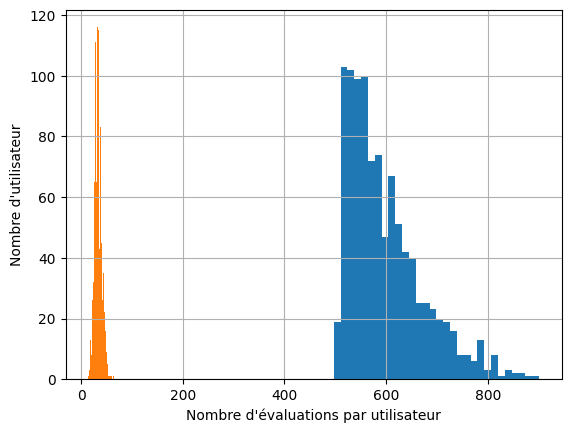

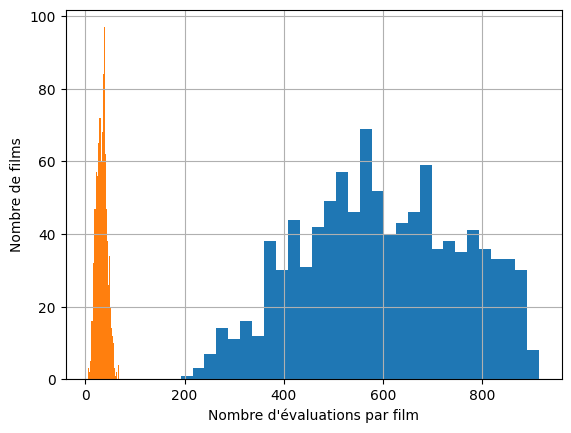

598095 33227


In [116]:
import matplotlib.pyplot as plt

ratings_per_user_val = valid_df.groupby('newUserId')["rating"].count()

ratings_per_user.hist(bins=30)
ratings_per_user_val.hist(bins=30)
plt.xlabel("Nombre d'évaluations par utilisateur")
plt.ylabel("Nombre d'utilisateur")
plt.show()

train_df.groupby('newMovieId')["rating"].count().hist(bins=30)
valid_df.groupby('newMovieId')["rating"].count().hist(bins=30)
plt.xlabel("Nombre d'évaluations par film")
plt.ylabel("Nombre de films")
plt.show()

print(len(train_df), len(valid_df))


*Réponse :* Au niveau du nombre de ratings par utilisateur, on observe qu'il y en a beaucoup moins dans les données de validation que les données d'entraînement. On obtient le même résultat pour les films. On peut donc en conclure qu'il y a en général moins d'évaluations dans les données de validation.

**1e.** Veuillez générer les matrices *utilisateurs x films* qui contiennent dans chaque cellule \[i, j\] le *rating* de l'utilisateur *i* pour le film *j*.  Si ce *rating* n'existe pas, la cellule vaut zéro.  Veuillez générer :
- la matrice `train_matrix` à partir de `train_df`
- la matrice `valid_matrix` à partir de `valid_df`

Quel est le taux de remplissage (cellules non nulles) de chaque matrice ?  On peut le calculer soit à partir des *dataframes*, soit directement sur les matrices.  Que pouvez-vous observer en comparant ces deux valeurs ?

In [117]:
def generate_matrix(df):    
    matrix = np.zeros((N_USERS, N_MOVIES))
    for _, row in df.iterrows():
        user = row['newUserId']
        movie = row['newMovieId']
        matrix[user, movie] = row['rating']
    return matrix

# Ajustement pour que les "newId" commencent à 0 et pas à 1
train_df['newUserId'] -= 1
train_df['newMovieId'] -= 1
valid_df['newUserId'] -= 1
valid_df['newMovieId'] -= 1

# Génération des matrices
train_matrix = generate_matrix(train_df)
valid_matrix = generate_matrix(valid_df)

In [118]:
MATRIX_SIZE = N_USERS * N_MOVIES

print("Taux de remplissage de la matrice d'entraînement :", np.count_nonzero(train_matrix) / MATRIX_SIZE)
print("Taux de remplissage de la matrice de validation :", np.count_nonzero(valid_matrix) / MATRIX_SIZE)

Taux de remplissage de la matrice d'entraînement : 0.598095
Taux de remplissage de la matrice de validation : 0.033227


*Réponse :* La matrice de validation est beaucoup plus creuse que la matrice d'entraînement.

## 2. Évaluation des systèmes "baseline"

Dans cette section, vous allez créer plusieurs systèmes *baseline* pour la comparaison, calculer leurs scores sur `valid_matrix` et les afficher.  Le calcul des scores vous est montré au point 2a.  Ces systèmes sont :
- **2a.** Prédiction des *ratings* comme valeurs aléatoires entre 1 et 10 (**code fourni**).
- **2b.** Prédiction des *ratings* par la moyenne de tous les *ratings* fournis dans `train_matrix`.
- **2c.** Prédiction des *ratings* d'un utilisateur par la moyenne de ses *ratings* fournis dans `train_matrix`.
- **2d.** Prédiction des *ratings* d'un film par la moyenne de ses *ratings* fournis dans `train_matrix`.
- **2e.** Prédiction de votre choix, par une combinaison des éléments de (b), (c) et (d).

In [119]:
from sklearn.metrics import root_mean_squared_error

# 2a. Voici comment calculer la Root Mean Squared Error (RMSE) des prédictions par rapport aux ratings de valid_matrix.
valid_vector = valid_matrix[valid_matrix.nonzero()] # suite des ratings non-nuls de valid_matrix

predict_2a = np.random.randint(1, 11, (len(valid_vector), 1)) # ratings aléatoires pour les utilisateurs x films 

rmse_2a = root_mean_squared_error(valid_vector, predict_2a)

print(f'RMSE en faisant des prédictions aléatoires entre 1 et 11 : {round(rmse_2a, 4)}')

RMSE en faisant des prédictions aléatoires entre 1 et 11 : 3.7868


In [120]:
# 2b -- veuillez écrire votre code ici et afficher le score RMSE

mean_rating = train_df['rating'].mean()
predict_2b = np.full((len(valid_vector), 1), mean_rating)
rmse_2b = root_mean_squared_error(valid_vector, predict_2b)
print(f'RMSE en faisant la moyenne des ratings : {round(rmse_2b, 4)}')


RMSE en faisant la moyenne des ratings : 2.0228


In [121]:
# 2c -- veuillez écrire votre code ici et afficher le score RMSE
mean_user_ratings = train_df.groupby('newUserId')['rating'].mean()

predict_2c = np.array([mean_user_ratings[user] for user in valid_df['newUserId']]).reshape(-1,1)
rmse_2c = root_mean_squared_error(valid_df['rating'], predict_2c)
print(f'RMSE en faisant la moyenne des ratings par utilisateur : {round(rmse_2c, 4)}')


RMSE en faisant la moyenne des ratings par utilisateur : 1.8535


In [122]:
# 2d -- veuillez écrire votre code ici et afficher le score RMSE
mean_movie_ratings = train_df.groupby('newMovieId')['rating'].mean()
predict_2d = np.array([mean_movie_ratings[movie] for movie in valid_df['newMovieId']]).reshape(-1,1)
rmse_2d = root_mean_squared_error(valid_df['rating'], predict_2d)
print(f'RMSE en faisant la moyenne des ratings par film : {round(rmse_2d, 4)}')


RMSE en faisant la moyenne des ratings par film : 1.7767


In [123]:
# 2e -- veuillez écrire votre code ici et afficher le score RMSE

predict_2e = np.add(predict_2c, predict_2d) / 2
rmse_2e = root_mean_squared_error(valid_df['rating'], predict_2e)
print(f'RMSE en faisant la moyenne des deux derniers tableaux de prédiction : {round(rmse_2e, 4)}')


RMSE en faisant la moyenne des deux derniers tableaux de prédiction : 1.7061


**2f.** Veuillez recopier ici les scores obtenus et commenter leurs différences.

In [124]:
print(f'RMSE en faisant des prédictions aléatoires entre 1 et 11 : {round(rmse_2a, 4)}')
print(f'RMSE en faisant la moyenne des ratings : {round(rmse_2b, 4)}')
print(f'RMSE en faisant la moyenne des ratings par utilisateur : {round(rmse_2c, 4)}')
print(f'RMSE en faisant la moyenne des ratings par film : {round(rmse_2d, 4)}')
print(f'RMSE en faisant la moyenne des deux derniers tableaux de prédiction : {round(rmse_2e, 4)}')

RMSE en faisant des prédictions aléatoires entre 1 et 11 : 3.7868
RMSE en faisant la moyenne des ratings : 2.0228
RMSE en faisant la moyenne des ratings par utilisateur : 1.8535
RMSE en faisant la moyenne des ratings par film : 1.7767
RMSE en faisant la moyenne des deux derniers tableaux de prédiction : 1.7061


*Réponse :* La meilleure approche parmis les propositions était la moyenne par film. Nous pensons que ce résultat est logique car il y a probablement moins de variance dans la note donnée à un film en général que dans les notes données par un utilisateur sur tous les films qu'il a vu. Cependant, nous avons obtenu les meilleurs résultats avec notre approche consistant à prendre en compte la moyenne par film et de la moyenne par utilisateur (en moyennant les deux vecteurs, par élément).

## 3. Filtrage collaboratif basé sur les exemples : modèle utilisateur-utilisateur

Dans cette partie, vous allez implémenter et tester les modèles de filtrage collaboratif *"memory-based"* qui calculent les *ratings* prédits pour chaque utilisateur selon les films les plus appréciés par les utilisateurs semblables.  Les formules pour ce modèle ont été données en cours.  Il faudra faire attention aux sous-ensembles sur lesquels sont calculées les différentes sommes.

**3a.** Veuillez calculer les *ratings* moyens de chaque utilisateur et les stocker dans un tableau nommé `mean_user_ratings`.

Attention, il ne faut pas inclure les valeurs nulles dans le calcul de ces moyennes.  Les zéros ne sont pas de vrais scores (*ratings*) mais indiquent l'absence de score.  Si on les incluait, les moyennes seraient toutes très basses.

**3b.** *Memory-based collaborative filtering: user-user model.*  Veuillez implémenter la formule vue en cours pour calculer la matrice `sim`.  Il s'agit d'un coefficient de similarité entre deux utilisateurs, sur la base des *ratings* qu'ils ont formulés pour les films qu'ils ont jugés en commun.  On utilise la corrélation de Pearson, mais restreinte aux films communs, c'est-à-dire ceux avec des *ratings* non nuls des deux utilisateurs.  Pour cette raison, on ne peut pas appliquer directement la fonction `numpy.corrcoef()` sur `train_matrix`, mais on doit effectuer le calcul explicitement.

In [125]:
# Initialisation de la matrice des similarités entre utilisateurs :
# sim[i, j] mesure la similarité entre les utilisateurs i et j.
# La matrice sera symétrique car sim[i, j] = sim[j, i], et elle peut
# avoir la diagonale nulle, car le modèle n'utilisera pas sim[i, i].

sim = np.zeros((N_USERS, N_USERS)) 

# Parcourir les ratings des utilisateurs i et j (avec i<j), c'est-à-dire 
# train_matrix[i] et train_matrix[j], retenir seulement les positions où
# les deux ratings sont >0, puis calculer le coefficient de corrélation.

for i in tqdm(range(N_USERS)):
    for j in range(i+1, N_USERS):
        ratings_user_i = train_matrix[i,:]
        ratings_user_j = train_matrix[j,:]

        common_mask = (ratings_user_i > 0) & (ratings_user_j > 0)
        if np.sum(common_mask) >= 2:
            common_ratings_i = ratings_user_i[common_mask]
            common_ratings_j = ratings_user_j[common_mask]

            corr = abs(np.corrcoef(common_ratings_i, common_ratings_j)[0,1])
            sim[i,j] = corr
            sim[j,i] = corr
            

100%|██████████| 1000/1000 [00:26<00:00, 37.38it/s]


In [126]:
# Une fonction auxiliaire utile.  Elle retourne une copie du vecteur 
# qui garde ses n plus grandes valeurs et met les autres à zéro.
def highest(array, n):
    if n >= len(array) or n < 0:
        return array.copy()
    else:
        threshold = sorted(array, reverse=True)[n-1]
        result = array.copy()
        result[result<threshold]=0
        return result

In [127]:
# Test de la fonction : retourne une copie de arr1 qui garde seulement
# ses 2 plus grands éléments, puis la même chose mais en gardant les
# deux plus grands éléments qui se trouvent à des emplacements non nuls
# de arr2 (cet exemple servira au 3c).
arr1 = np.array([1, 2, 5, 0, 9, 7])
arr2 = np.array([3, 0, 2, 0, 0, 7])
print(arr1, highest(arr1, 2), arr2)
print(arr1, highest(arr1 * np.where(arr2 > 0, 1, 0), 2), arr2)

[1 2 5 0 9 7] [0 0 0 0 9 7] [3 0 2 0 0 7]
[1 2 5 0 9 7] [0 0 5 0 0 7] [3 0 2 0 0 7]


**3c.** Veuillez calculer les *ratings* prédits par le système pour tous les utilisateurs et les items (comme au 2c et 2d mais chaque cellule doit être calculée avec la formule vue en cours).  Essayez d'optimiser le nombre d'utilisateurs semblables que vous retenez dans la formule.

In [128]:
N_BEST_USERS = 100
preds = []

print(len(mean_user_ratings))

for _, row in tqdm(valid_df.iterrows()):
    u = row['newUserId']
    m = row['newMovieId']

    mean_for_u = mean_user_ratings[u]
    sim_u = sim[u,:]

    r_i = train_matrix[:,m]
    sim_u = highest(sim_u * np.where(r_i > 0, 1, 0), N_BEST_USERS)

    sumOfSimTimesRatings = np.sum(sim_u * (r_i - mean_user_ratings))    
    prediction = mean_for_u + sumOfSimTimesRatings / np.sum(sim_u)

    preds.append(prediction)

    # Uncomment to see evolution of rmse in real time
    #if _ % 1000 == 0 and _ > 1:
    #    rmse = root_mean_squared_error(valid_vector[:_], preds[:_])
    #    print(rmse)

1000


33227it [00:13, 2505.38it/s]


**3d.** Veuillez évaluer les *ratings* prédits en les comparant avec les *ratings* fournis par `valid_vector` calculé plus haut.  Comment se compare le résultat avec les scores du 2f ?

In [129]:
rmse_user_similarity = root_mean_squared_error(valid_vector, preds)
print(rmse_user_similarity)

2.5113416968946716


*Réponse :* Malheureusement, les résultats sont beaucoup moins bons que les méthodes précédentes. Nous pensons que notre implémentation doit contenir des bugs mais nous n'avons malheureusement pas réussi à en trouver la source.

## 4. Filtrage collaboratif basé sur les exemples : modèle film-film

Dans cette partie, vous allez implémenter et tester les modèles de filtrage collaboratif *"memory-based"* qui calculent les *ratings* prédits pour un film selon les utilisateurs qui ont le plus apprécié les films semblables (modèle réciproque du précédent).  Les formules pour ce modèle ont été données en cours.  Il faudra faire attention aux sous-ensembles sur lesquels sont calculées les différentes sommes.

**4a.** Veuillez calculer les *ratings* moyens de chaque film et les stocker dans un tableau nommé `mean_movie_ratings`.  

Attention, il ne faut pas inclure les valeurs nulles dans le calcul de ces moyennes.  Les zéros ne sont pas de vrais scores (*ratings*) mais indiquent l'absence de score.

In [130]:
mean_item_ratings = train_df.groupby('newMovieId')['rating'].mean()

**4b.** *Memory-based collaborative filtering: item-item model.*  Veuillez implémenter la formule vue en cours pour calculer la matrice `sim_item`.  Il s'agit d'un coefficient de similarité entre deux films (items), sur la base des *ratings* qu'ils ont reçus des utilisateurs qui se sont exprimés sur les deux films.  On utilise la corrélation de Pearson, mais restreinte aux utilisateurs communs, c'est-à-dire ceux avec des *ratings* non nuls des deux films.  Pour cette raison, on ne peut pas appliquer directement la fonction `numpy.corrcoef()` sur `train_matrix`, mais on doit effectuer le calcul explicitement.  Le code est très similaire au point 3b.

In [131]:
# Initialisation de la matrice des similarités entre films :
# sim_item[i, j] mesure la similarité entre les films i et j.
# La matrice sera symétrique car sim[i, j] = sim[j, i], et elle peut
# avoir la diagonale nulle, car le modèle n'utilisera pas sim[i, i].
sim_item = np.zeros((N_MOVIES, N_MOVIES)) 

# Parcourir les ratings des films i et j (avec i<j), c'est-à-dire 
# train_matrix[:,i] et train_matrix[:,j], retenir seulement les positions où
# les deux ratings sont >0, puis calculer le coefficient de corrélation.

for i in tqdm(range(N_MOVIES)):
    for j in range(i+1, N_MOVIES):
        movie_i = train_matrix[:,i]
        movie_j = train_matrix[:,j]

        common_mask = (movie_i > 0) & (movie_j > 0)
        if np.sum(common_mask) >= 2: # au moins deux éléments trouvés
            common_ratings_i = movie_i[common_mask]
            common_ratings_j = movie_j[common_mask]

            corr = np.corrcoef(common_ratings_i, common_ratings_j)[0,1]
            sim_item[i,j] = corr
            sim_item[j,i] = corr


100%|██████████| 1000/1000 [00:31<00:00, 31.76it/s]


**4c.** Veuillez calculer les *ratings* prédits par le système pour tous les utilisateurs et les items (analogue au 3c).  Essayez d'optimiser le nombre d'films semblables que vous utilisez dans la formule.

In [141]:
N_BEST_MOVIES = 100
preds = []

for _, row in tqdm(valid_df.iterrows()):
    u = row['newUserId'] - 1
    m = row['newMovieId'] - 1

    sim_m = sim_item[m,:]

    r_u = train_matrix[u,:]

    sim_m = highest(sim_m * np.where(r_u > 0, 1, 0), N_BEST_MOVIES)
    
    prediction = sum(sim_u * r_i) / np.sum(sim_m)

    preds.append(prediction)


33227it [00:11, 2891.57it/s]


**4d.** Veuillez évaluer les *ratings* prédits en les comparant avec les *ratings* fournis par `valid_vector` calculé plus haut.  Comment se compare le résultat avec les scores du 2f et ceux du 3d ?

In [142]:
rmse_user_similarity = root_mean_squared_error(valid_vector, preds)
print(rmse_user_similarity)

2.9344317692699686


*Analyse :* De nouveau, c'est un très mauvais résultat (moins bon que les modèles baseline). Il doit sûrement y avoir un problème avec notre implémentation.

## 5. Filtrage collaboratif par factorisation de matrices

Dans cette section, vous allez mettre en place un modèle de prédiction des *ratings* utilisant la factorisation de matrices, comme vu en cours.  Vous calculerez deux matrices U et V, telles que R = U.T x V où R est la matrice des *ratings* (U.T désigne la transposée de U).  Le calcul direct d'une SVD ne fonctionne pas, car la matrice R (ici, `train_matrix`) contient beaucoup de 0 qui signifient en réalité des *ratings* inconnus.  Vous utiliserez comme données d'entraînement directement celles de `train_df`. 

L'hyperparamètre à régler est la dimension réduite de U et de V, notée `n_latent_factors`.

Vous utiliserez une approche par descente de gradient, implémentée en Keras, qui utilisera seulement les *ratings* connus (non nuls) pour s'entraîner.  Après avoir calculé U et V, vous pourrez estimer toutes les valeurs inconnues de R, puisque R = U.T x V -- il suffira pour cela d'utiliser le modèle en mode prédiction.

Vous évaluerez le résultat en comparant ces estimations avec les *ratings* connus de `valid_df`. 

In [143]:
import keras
from tensorflow.keras.layers import Input, Embedding, Flatten, dot
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import RootMeanSquaredError

**5a.** Veuillez définir le modèle Keras qui prend en entrée l'index de l'utilisateur et l'index du film, et produit en sortie le *rating* estimé comme le produit scalaire des embeddings des entrées (*voir le cours*).  Finir par la compilation du modèle selon la ligne de code fournie.

In [144]:
# Définition du modèle
n_latent_factors = 40
 
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=N_USERS + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)
 
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=N_MOVIES + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
 
product = dot([movie_vec, user_vec], axes=1)

**5b.** Veuillez entraîner le modèle pendant un certain nombre d'époques et sauvegarder l'historique des scores.

In [145]:
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError()])
 
nbrEpochs = 15
 
# Entraînement du modèle
history = model.fit(x=[train_df['newUserId'], train_df['newMovieId']], y=train_df['rating'],
                    batch_size=128, epochs=nbrEpochs, verbose=1,
                    validation_data=([valid_df['newUserId'], valid_df['newMovieId']], valid_df['rating']))

Epoch 1/15
4673/4673 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 25.2398 - root_mean_squared_error: 4.8453 - val_loss: 2.6096 - val_root_mean_squared_error: 1.6154
Epoch 2/15
4673/4673 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 2.6116 - root_mean_squared_error: 1.6160 - val_loss: 2.5887 - val_root_mean_squared_error: 1.6090
Epoch 3/15
4673/4673 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 2.5578 - root_mean_squared_error: 1.5993 - val_loss: 2.4651 - val_root_mean_squared_error: 1.5701
Epoch 4/15
4673/4673 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 2.4281 - root_mean_squared_error: 1.5582 - val_loss: 2.3843 - val_root_mean_squared_error: 1.5441
Epoch 5/15
4673/4673 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 2.3556 - root_mean_squared_error: 1.5348 - val_loss: 2.3324 - val_root_mean_squared_error: 1.5272
Epoch 6/15
4673/4673 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 2.2874 - root_mean_squared_error: 1.5124 - val_loss: 2.2892 - val_root_mean_squared_error: 1.5130
Epoch 7/15
4673/4673 ━━━━━━━━━━━━

**5c.** Veuillez afficher sur un graphique l'évolution de la RMSE sur les données de validation (`valid_df`) au cours de l'entraînement.  Veuillez afficher aussi séparément la meilleure valeur de RMSE.  Après plusieurs expériences, veuillez laisser un graphique qui montre que l'apprentissage est satisfaisant et expliquer pourquoi. 

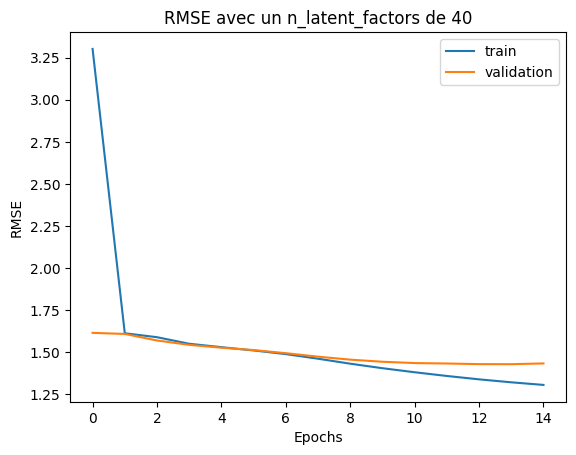

Best RMSE on validation :  1.4293062686920166  at epoch 14


In [146]:
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE avec un n_latent_factors de ' + str(n_latent_factors))
plt.legend()
plt.show()
 
print("Best RMSE on validation : ", min(history.history['val_root_mean_squared_error']), " at epoch", np.argmin(history.history['val_root_mean_squared_error'])+1)

*Analyse :* Après avoir fait plusieurs tests, nous avons remarqué que, au delà de 10 epochs, la RMSE sur la validation arrêtait d'augmenter.

**5d.** Effectuez plusieurs expériences et décrivez-les brièvement ici, pour déterminer votre meilleur modèle -- c'est à dire les valeurs optimales de `n_latent_factors` et du nombre d'époques.  Utilisez comme critère la RMSE sur les données de validation.  Si ce modèle est meilleur que ceux du (3) ou du (4), veuillez le sauvegarder à l'aide de la fonction [save](https://keras.io/guides/serialization_and_saving/) de Keras pour le soumettre à la compétition.

In [147]:
model.save('model_AncayCharbonnier.h5')

*Analyse :* Nous avons effectué des tests avec différentes valeurs de `n_latent_factors` et du nombre d'epochs. Nous avons trouvé que les meilleurs résultats étaient obtenus avec **40 facteurs latents** et **~13 époques**. Nous avons obtenu une RMSE de **1.4250** sur les données de validation.
Ce modèle est meilleur que ceux du (3) et du (4).

**Fin du Labo 8.**  Veuillez nettoyer ce notebook, afficher les résultats et les commentaires demandés, l'enregistrer, et le soumettre comme devoir sur Cyberlearn.  

Ne pas oublier de soumettre également votre meilleur système avec le code nécessaire pour l'évaluer sur des données de test similaires à celles de validation.